In [1]:
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib.pyplot as plt

# Loading J-PLUS data
print 'Loading J-PLUS'
mag_type = 'gpsfMags'
gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='idr', allphotoz=True, upperlimparams=True)


print 'Computing 3FM'
dm_min = 0.2 # rough number, to be computed as a function using the actual trumpet plots for individual tiles.

gal_jplus['dm'] = mtools.gen_3fm(gal_jplus['J0660'][:,0],  gal_jplus['rJAVA'][:,0], gal_jplus['gJAVA'][:,0], 
                         Broad_NoLineName='gSDSS')

gal_jplus['err_dm'] = mtools.gen_3fm_err(gal_jplus['J0660'][:,0], gal_jplus['J0660'][:,1], 
                                         gal_jplus['rJAVA'][:,0], gal_jplus['rJAVA'][:,1], 
                          gal_jplus['gJAVA'][:,0], gal_jplus['gJAVA'][:,1],Broad_NoLineName='gSDSS')

print 'setting redshift ranges of ELGs'
f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)
        
w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)

print z_oii, z_ha, z_hb, z_oiii

j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_idr_dual_magmax24.0.h5


Loading J-PLUS
Computing 3FM
setting redshift ranges of ELGs


j-plus [INFO]: Fetching  J-PLUS filters


[0.7482142815072982, 0.7964311035074512] [-0.007223125525262806, 0.020158269506669296] [0.3403815320258589, 0.3773500766863342] [0.30129710948226485, 0.3371876817999342]


In [2]:
print 'Loading 3D-HST and DEEP2'
# Loading 3D-HST and DEEP2 DR4 data

hstdata = hst.select_3DHST_z(0,5)#,LineName='Ha_flux',LineMin=0.001)
nhst = len(hstdata['ra'])
hst_coords = np.zeros([nhst,2])

for i in range(nhst):
    hst_coords[i,:] = [hstdata['ra'][i],hstdata['dec'][i]]
hstdata['coords'] = hst_coords

deep2_data = '/home/CEFCA/aaorsi/work/elg_jplus/spec/deep2/dr4/zcat.deep2.dr4.fits'
deep2 = fits.open(deep2_data)[1].data


# XMatch with 3DHST
print 'xmatch with 3DHST'
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],hstdata['coords'],max_distance=3e-3)
m = ((d != np.inf))

jhst0 = jplus.tools.select_object(gal_jplus, m)
jhst0['z_spec'] = hstdata['z'][ind[m]]

elg_hst =  ((jhst0['dm'] > dm_min) &
            (((jhst0['z_spec'] > z_ha[0])   & (jhst0['z_spec'] < z_ha[1]))   |
           ((jhst0['z_spec'] > z_hb[0])   & (jhst0['z_spec'] < z_hb[1]))   |
           ((jhst0['z_spec'] > z_oiii[0]) & (jhst0['z_spec'] < z_oiii[1])) |
           ((jhst0['z_spec'] > z_oii[0])  & (jhst0['z_spec'] < z_oii[1]))))

jhst = jplus.tools.select_object(jhst0, elg_hst)
nhst = len(jhst['z_spec'])
jhst['idd'] = np.arange(nhst)


# xmatch with DEEP2
print 'xmatch with DEEP2'
d2mask = ((deep2['ZQUALITY'] > 2) &  # Select only Deep2 objects with good quality Redshifts
        (deep2['Z'] <= z_ha[1]) |
           ((deep2['Z'] >= z_hb[0])   &   (deep2['Z'] <= z_hb[1]))   |
           ((deep2['Z'] >= z_oiii[0]) &   (deep2['Z'] <= z_oiii[1])) |
           ((deep2['Z'] >= z_oii[0])  &   (deep2['Z'] <= z_oii[1])))
          
          
ndeep2 = len(deep2['RA'][d2mask])
dcoords = np.asarray([[deep2['RA'][d2mask][i], deep2['DEC'][d2mask][i]] for i in range(ndeep2)])
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],dcoords,max_distance=3e-3)
m = ((d != np.inf))

jdeep2 = jplus.tools.select_object(gal_jplus, m & (gal_jplus['dm'] > dm_min))
jdeep2['z_spec'] = deep2['Z'][d2mask][ind[m & (gal_jplus['dm'] > dm_min)]]
ndeep2 = len(jdeep2['z_spec'])
#jdeep2['idd'] = np.arange(ndeep2)
print jdeep2['z_spec']
print 'Done loading data!'

Loading 3D-HST and DEEP2
xmatch with 3DHST
xmatch with DEEP2
[ 0.31466761  0.35483444  0.35719907  0.33090267  0.7756151   0.35132754
  0.75012684  0.37277409  0.33354449  0.32794198  0.31301913  0.35657647
  0.35451496  0.7715618   0.37176737  0.30759287  0.35510534  0.35438871
  0.01540997  0.37501061  0.35485289  0.76541924  0.35522157  0.76166385
  0.76262033  0.75458628  0.32501391  0.76035857  0.79290611  0.31132224
  0.75563228  0.37058023  0.75935072  0.75569975  0.37706569  0.37163761
  0.76766104  0.36804396  0.76745284  0.37415349  0.33301318  0.37111458
  0.32529244  0.75676161  0.782152    0.35535344  0.35513747  0.77290154
  0.76971471  0.35308605  0.77016765  0.78870094  0.35725969  0.75106317
  0.75457811  0.76852775  0.35093918  0.75195217  0.75080711  0.76442057
  0.75500995  0.37285197  0.35493267  0.78022605  0.36689448]
Done loading data!


In [3]:
print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))

j_alh = jplus.tools.select_object(gal_jplus, alh_m)
print 'Cross match between Alhambra and J-PLUS results in %ld objects' % len(j_alh['tile_id'])
j_alh['z_spec'] = alh['zphoto'][alh_ind[alh_m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  ((j_alh['dm'] > dm_min) &
            (((j_alh['z_spec'] > z_ha[0])   & (j_alh['z_spec'] < z_ha[1]))   |
           ((j_alh['z_spec'] > z_hb[0])   & (j_alh['z_spec'] < z_hb[1]))   |
           ((j_alh['z_spec'] > z_oiii[0]) & (j_alh['z_spec'] < z_oiii[1])) |
           ((j_alh['z_spec'] > z_oii[0])  & (j_alh['z_spec'] < z_oii[1]))))


plt.hist(j_alh['z_spec'][mask_elgs], bins=50)
nalh = len(j_alh['z_spec'][mask_elgs])

j_alhambra = jplus.tools.select_object(j_alh, mask_elgs)

print nalh


Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
Cross match between Alhambra and J-PLUS results in 6415 objects
168


In [4]:
# Loading SDSS data

gal_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="galaxies")

print 'Cross-match of SDSS phot with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],gal_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

j_spec = jplus.tools.select_object(gal_jplus, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
j_spec['rSDSS'] = gal_sdss_spec['rSDSS'][ind[m]]
j_spec['iSDSS'] = gal_sdss_spec['iSDSS'][ind[m]]
j_spec['uSDSS'] = gal_sdss_spec['uSDSS'][ind[m]]
j_spec['gSDSS'] = gal_sdss_spec['gSDSS'][ind[m]]
j_spec['zSDSS'] = gal_sdss_spec['zSDSS'][ind[m]]
j_spec['z_spec'] = gal_sdss_spec['zspec'][ind[m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  ((j_spec['dm'] > dm_min) &
            (((j_spec['z_spec'] > z_ha[0])   & (j_spec['z_spec'] < z_ha[1]))   |
           ((j_spec['z_spec'] > z_hb[0])   & (j_spec['z_spec'] < z_hb[1]))   |
           ((j_spec['z_spec'] > z_oiii[0]) & (j_spec['z_spec'] < z_oiii[1])) |
           ((j_spec['z_spec'] > z_oii[0])  & (j_spec['z_spec'] < z_oii[1]))))


plt.hist(j_spec['z_spec'][mask_elgs], bins=50)
nsdss = len(j_spec['z_spec'][mask_elgs])

j_sdss = jplus.tools.select_object(j_spec, mask_elgs)

print nsdss


j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax21.0.h5


Cross-match of SDSS phot with J-PLUS ...
xmatch catalogue contains 88206 galaxies
594


In [5]:
%matplotlib inline
import matplotlib.gridspec as gsc

training_frac = 0.4 # the rest is for testing
ngals_tot = ndeep2 + nhst + nsdss + nalh
print 'Total number of galaxies used in data set: %d'%ngals_tot

dataspec = {}

for key in jdeep2:
    if key == 'date' or key == 'SQL_query' or key == 'filename':
        continue
    value_hst   = jhst[key]
    value_deep2 = jdeep2[key]
    value_sdss  = j_sdss[key]
    value_alh   = j_alhambra[key]
    shape = value_deep2.shape
    ndim = value_deep2.ndim
    dataspec[key] = np.zeros(ngals_tot) if ndim == 1 else np.zeros([ngals_tot, shape[1]])
    dataspec[key][0:ndeep2] = value_deep2
    dataspec[key][ndeep2:ndeep2+nhst] = value_hst   
    dataspec[key][ndeep2+nhst:ndeep2+nhst+nsdss] = value_sdss   
    dataspec[key][ndeep2+nhst+nsdss:] = value_alh   

dataspec['type'] = []
for i in range(ndeep2):
    dataspec['type'].append('DEEP2')
for i in range(nhst):
    dataspec['type'].append('3D-HST')
for i in range(nsdss):
    dataspec['type'].append('SDSS')
for i in range(nalh):
    dataspec['type'].append('Alhambra')
    
dataspec['index'] = np.arange(ndeep2 + nhst+nsdss+nalh)    





Total number of galaxies used in data set: 834


In [6]:
print 23**2

529


In [7]:
# Plot all dataset
Plot_TrainingSet = False
import matplotlib.pyplot as plt

if Plot_TrainingSet:

    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
                #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

    sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
    sdss_mw     = [3543, 4770, 6231, 7625, 9134]

  
    grid = [30,30]
    gs = gsc.GridSpec(grid[0],grid[1])
    gs.update(wspace=0.035, hspace=0.035)

    plt.rcParams['figure.figsize'] = 60, 60

    
    nxm = len(dataspec['tile_id'])
    print 'Number of xmatched ELGs: %ld'%nxm
    dataspec['dm'] = mtools.gen_3fm(dataspec['J0660'][:,0], dataspec['rJAVA'][:,0], 
                              dataspec['iJAVA'][:,0],Broad_NoLineName='iSDSS')

    ix = 0
    iy = 0
    idg = 0

    sortz = np.argsort(dataspec['z_spec'])

    for i0 in range(nxm):
        i = sortz[i0]
        ax= plt.subplot(gs[ix,iy])
        idg = ix + grid[0]*iy
        for fname in filternames:
            filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
    #        print np.median(filt.wave)
            ww = [filt.avgwave(), filt.avgwave()]
            ff = [dataspec[fname][i,0], dataspec[fname][i,0]]

            ax.plot(ww,ff,'o', color='blue', markersize=10)
            ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='blue')


            if fname == 'J0660':# or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
                fwidth = filt.rectwidth()
                ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                            [19,19, 24, 24],facecolor='Grey',alpha=0.2)
        fw = 0   
        if sdss_fnames[0] in dataspec: # if sdss bands exist
            for fname in sdss_fnames:
                filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
    #        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                ww = [sdss_mw[fw], sdss_mw[fw]]
                fw += 1
                ff = [dataspec[fname][i,0], dataspec[fname][i,0]]
                ax.plot(ww,ff,'o', color='red', markersize=10)
                ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='red')

        ax.text(0.3,0.9,r'$z_{\rm spec}=%.2f$'%dataspec['z_spec'][i], transform= ax.transAxes, fontsize=12)
        ax.text(0.3,0.8,r'$\Delta m=%.2f$'%dataspec['dm'][i], transform= ax.transAxes, fontsize=12, color='red')
        ax.text(0.3,0.7,dataspec['type'][i], transform= ax.transAxes, fontsize=12, color='black')
        ax.text(0.1,0.9,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
        ax.set_ylim([24, 18.99])
        ax.set_xlim([3000, 8999])
        if ix != grid[0]-1:
            ax.set_xticklabels([])
        if iy >0:
            ax.set_yticklabels([])
        ix +=1
        if ix == grid[0]:
            ix = 0
            iy += 1

    plt.show()        



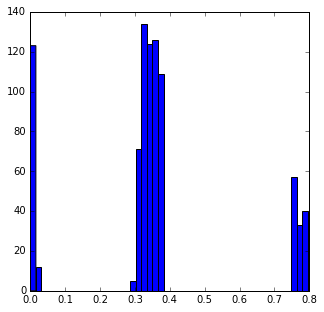

In [8]:
plt.rcParams['figure.figsize'] = 5, 5
plt.hist(dataspec['z_spec'],bins=50)
plt.show()

In [9]:
# Classifying the full set of galaxies
dataspec['class'] = []
for i in range(ngals_tot):
    zp = dataspec['z_spec'][i]
    if zp < z_ha[1]:
        dataspec['class'].append('Halpha')
    elif (zp > z_ha[1]) and (zp < z_oiii[1]):
        dataspec['class'].append('OIII')
    elif (zp > z_oiii[1]) and (zp < z_hb[1]):
        dataspec['class'].append('Hbeta')
    elif (zp > 0.5):
        dataspec['class'].append('OII')
    else:
        print 'something is wrong with this redshift: %f'%zp

m_z0  = np.asarray(dataspec['class']) == 'Halpha'
m_zp3 = np.asarray(dataspec['class']) == 'OIII'
m_zp35 = np.asarray(dataspec['class']) == 'Hbeta'
m_zp7 = np.asarray(dataspec['class']) == 'OII'

nz0  = len(dataspec['z_spec'][m_z0])
nzp3 = len(dataspec['z_spec'][m_zp3])  
nzp35 = len(dataspec['z_spec'][m_zp35])  
nzp7 = len(dataspec['z_spec'][m_zp7])
print 'Number of Halpha emitters: %ld' % nz0
print 'Number of OIII emitters: %ld' % nzp3       
print 'Number of Hbeta emitters: %ld' % nzp35
print 'Number of OII emitters: %ld' % nzp7


Number of Halpha emitters: 135
Number of OIII emitters: 250
Number of Hbeta emitters: 319
Number of OII emitters: 130


In [10]:
print dataspec['mu_max_r'][0]
print dataspec.keys()
#dataspec['cstar']

23.5597496
['flag_uJAVA', 'mask_flags_iJAVA', 'norm_wmap_val_uJAVA', 'J0395', 'flag_J0660', 'flag_J0861', 'flag_J0515', 'pz_bpz_err', 'ISOAREA_WORLD', 'flag_J0430', 'mask_flags_J0660', 'J0861', 'object_id', 'single_detect_J0395', 'pz_leph', 'single_detect_J0378', 'J0410', 'fwhm', 'flag_J0378', 'mask_flags_gJAVA', 'pz_bpz', 'index', 'norm_wmap_val_zJAVA', 'pz_tpz', 'mask_flags_J0395', 'pz_leph_err', 'mask_flags_J0861', 'pz_tpz_err', 'single_detect_iJAVA', 'J0430', 'single_detect_gJAVA', 'mag_auto_r', 'norm_wmap_val_iJAVA', 'mask_flags_J0410', 'mu_max_r', 'flag_zJAVA', 'zJAVA', 'mask_flags_J0515', 'mask_flags_J0430', 'norm_wmap_val_gJAVA', 'type', 'single_detect_uJAVA', 'uJAVA', 'norm_wmap_val_J0515', 'dm', 'single_detect_J0861', 'single_detect_J0430', 'norm_wmap_val_J0430', 'norm_wmap_val_J0410', 'class', 'norm_wmap_val_J0395', 'single_detect_rJAVA', 'err_dm', 'mask_flags_uJAVA', 'single_detect_zJAVA', 'kron_rad', 'norm_wmap_val_J0861', 'single_detect_J0410', 'iJAVA', 'z_spec', 'tile_id

In [11]:
# This function retrieves a features list for a single object.

def prepare_sample(data, index, sample_error = True, sample_type = 'All_Mags'):
    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
    
    flist = [] # filterslist
    ferrlist = []
    nfilters = len(filternames)
    amplitude = np.random.normal(0, 2.0) # amplitude scaling change 
    for ff in filternames:
        if sample_error:
            flist.append(np.random.normal(data[ff][index,0], data[ff][index,1]) + amplitude)  # errors distribute like a gaussian (?)
        else:
            flist.append(data[ff][index,0])
        ferrlist.append(data[ff][index,1])
    
    sample = [] # The sample's features
    
    dm_J0515 = mtools.gen_3fm(data['J0515'][index,0], data['gJAVA'][index,0], 
                          data['rJAVA'][index,0],Broad_NoLineName='rSDSS', LineFilterName='J0515', 
                          Broad_LineName='gSDSS')
    err_dm_J0515 = mtools.gen_3fm_err(data['J0515'][index,0], data['J0515'][index,1], data['gJAVA'][index,0], 
                                      data['gJAVA'][index,1], data['rJAVA'][index,0], data['rJAVA'][index,1],
                                      Broad_NoLineName='rSDSS')


    dm_J0378 = mtools.gen_3fm(data['J0378'][index,0], data['uJAVA'][index,0], 
                          data['gJAVA'][index,0],Broad_NoLineName='gSDSS', LineFilterName='J0378', 
                              Broad_LineName='uJAVA')
    err_dm_J0378 = mtools.gen_3fm_err(data['J0378'][index,0], data['J0378'][index,1], data['uJAVA'][index,0], 
                                      data['uJAVA'][index,1],data['gJAVA'][index,0], data['gJAVA'][index,1],
                                      Broad_NoLineName='gSDSS')

    dm_J0861 = mtools.gen_3fm(data['J0861'][index,0], data['zJAVA'][index,0], 
                          data['iJAVA'][index,0],Broad_NoLineName='iSDSS', 
                          LineFilterName='J0861', Broad_LineName='zSDSS')

    err_dm_J0861 = mtools.gen_3fm_err(data['J0861'][index,0], data['J0861'][index,1], data['zJAVA'][index,0], 
                          data['zJAVA'][index,1],data['iJAVA'][index,0], data['iJAVA'][index,1],
                          Broad_NoLineName='iSDSS')

    
    # Here I should get creative
    if sample_type == 'All_Mags':
        sample = flist # All individual filters
    if sample_type == 'All_Mags_mumax':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        #sample.append(data['cstar'][index])
#        sample.append(data['pz_bpz'][index])
    if sample_type == 'Colors':
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j])
                   
    if sample_type == 'All':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index])
        #sample.append(data['cstar'][index])
        sample.append(data['pz_bpz'][index])
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j]) 
    if sample_type == 'dm':
        sample=[dm_J0515, err_dm_J0515,
#                dm_J0378, err_dm_J0378,
                dm_J0861, err_dm_J0861,
                data['dm'][index],data['err_dm'][index]]
        sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        sample.append(data['gJAVA'][index,0])
        sample.append(data['rJAVA'][index,0])
        sample.append(data['iJAVA'][index,0])
        sample.append(data['zJAVA'][index,0])
        
#        sample.append(data['petro_rad'][index])
#        sample.append(data['kron_rad'][index])
#        sample.append(data['pz_bpz'][index])
#        sample.append(data['pz_leph'][index])

        

    return sample



In [12]:
Training_set_class_frac = 1 # a fraction X of the less abundant determines the number of objects per class in the training set.
Sampling_errors         = 1  # Each training galaxy is resampled X times using its errors

# indices of different categories of objects
id_z0   = dataspec['index'][m_z0] 
id_z0p3 = dataspec['index'][m_zp3]
id_z0p35 = dataspec['index'][m_zp35]
id_z0p7 = dataspec['index'][m_zp7]

min_class = np.min([nz0, nzp3, nzp35, nzp7])

UseFixedNum = False # Use a fixed number of objects per class

if UseFixedNum:
    numperclass = int(min_class*Training_set_class_frac)
    print 'number of objects in training set per class before sampling errors: %d'%numperclass
    print 'number of objects left for validation: %d'%(ngals_tot-numperclass*3)
    
# Randomised lists:
ran_idz0 = np.random.permutation(id_z0)
ran_idz0p3 = np.random.permutation(id_z0p3)    
ran_idz0p35 = np.random.permutation(id_z0p35)    
ran_idz0p7 = np.random.permutation(id_z0p7)

id_arr = [ran_idz0, ran_idz0p3, ran_idz0p35, ran_idz0p7]

training_features = []
training_class    = []

sample_type='dm'


for id_obj in id_arr:
    nid = numperclass if UseFixedNum else int(len(id_obj)*Training_set_class_frac)
    for i in range(nid):
        for j in range(Sampling_errors):
            training_features.append(prepare_sample(dataspec, id_obj[i], sample_error=False, 
                                                    sample_type=sample_type))
            training_class.append(dataspec['class'][id_obj[i]])



if Training_set_class_frac < 1:    # if == 1 then CV is used instead
    validate_features = []
    validate_class    = []

    for id_obj in id_arr:
        nid = len(id_obj)
        for i in range(numperclass, nid):
            validate_features.append(prepare_sample(dataspec, id_obj[i], sample_error=False, 
                                                    sample_type=sample_type))
            validate_class.append(dataspec['class'][id_obj[i]])


print 'number of objects in training set: %ld'%len(training_features)        
#for i in range(len(training_features)):
#    print training_features[i], training_class[i]
    
print 'Number of features: %ld' % len(training_features[0])

number of objects in training set: 834
Number of features: 11


{'test_precision_macro': array([ 0.65068543,  0.53151016,  0.61800725,  0.67261905,  0.61126118]), 'train_recall_macro': array([ 0.87868342,  0.86426778,  0.85368878,  0.53141229,  0.55083266]), 'score_time': array([ 0.00185394,  0.0017879 ,  0.00188613,  0.00239801,  0.00237513]), 'fit_time': array([ 1.27640104,  1.17049408,  1.1789279 ,  0.25475621,  0.19556904]), 'test_recall_macro': array([ 0.59957831,  0.47686025,  0.61031747,  0.50821677,  0.51961245]), 'train_precision_macro': array([ 0.89976434,  0.88472846,  0.87990942,  0.66640136,  0.64495733]), 'test_f1_macro': array([ 0.61598063,  0.49336724,  0.60570818,  0.5299661 ,  0.52871781]), 'train_f1_macro': array([ 0.88594189,  0.869344  ,  0.86126622,  0.55405149,  0.55290425])}
Metrics for MLP
             precision    recall  f1-score   support

     Halpha       0.80      0.80      0.80        50
       OIII       0.53      0.44      0.48       107
      Hbeta       0.58      0.69      0.63       129
        OII       0.62   

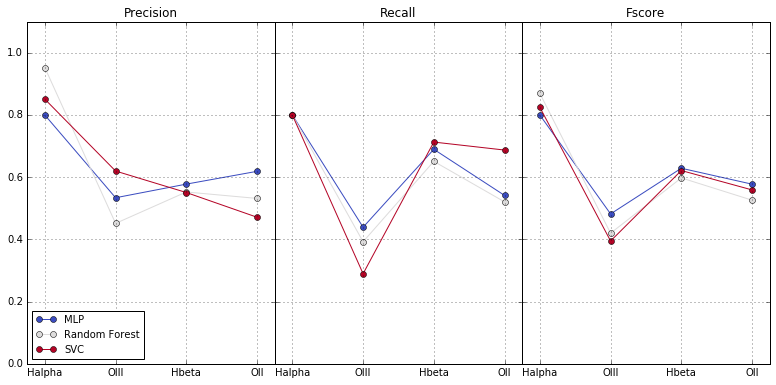

In [13]:
# Run ML
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn import tree
from sklearn import svm 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

if Training_set_class_frac == 1: # Do the splitting automatically instead of defined as above
     training_features, validate_features, training_class, validate_class = train_test_split(
     training_features, training_class, test_size=0.4, random_state=0)

Scaledata = True

if Scaledata:
    scaler = StandardScaler()
    scaler.fit(training_features)
    Traindata = scaler.transform(training_features)
    Testdata  = scaler.transform(validate_features)
else:
    Traindata = training_features
    Testdata  = validate_features

#classifier = MLPClassifier(solver='lbfgs')
C = 1.0
kernel = 1.0 * RBF([1.0,1.0,1.0,1.0,1.0,1.0]) # for GPC

classifiers = { 'MLP'                       : MLPClassifier(solver='adam',verbose=False, max_iter=1000),
                    'Random Forest'             : RandomForestClassifier(n_estimators=50),
                    'SVC'                       : svm.SVC(kernel='linear', class_weight='balanced'),
#                    'L1 logistic'               : LogisticRegression(C=C, penalty='l1'),
#                    'L2 logistic (OvR)'         : LogisticRegression(C=C, penalty='l2'),
#                    'L2 logistic (Multinomial)' : LogisticRegression(C=C, solver='lbfgs',multi_class='multinomial')
#                    'GPC'                       : GaussianProcessClassifier(kernel)
                    }

nclass = float(len(classifiers))
mlcolors = plt.cm.coolwarm(np.linspace(0,1,nclass))
plt.rcParams['figure.figsize'] = 10, 10

plt.figure(1)
gs = gsc.GridSpec(1,4)
gs.update(wspace=0.0, right=1.5,top=0.6)

cnum = [0, 1, 2, 3]
ctype = ['Halpha', 'OIII', 'Hbeta','OII']

for index, (name, classifier) in enumerate(classifiers.items()):

    classifier.fit(Traindata, training_class)
    y_pred = classifier.predict(Testdata)

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    scores = cross_validate(classifier, Traindata, training_class, scoring=scoring,
             cv=5, return_train_score=True)
    print scores
    
    print 'Metrics for %s'%name
    print metrics.classification_report(validate_class, y_pred, labels=ctype, )
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(validate_class, y_pred, labels=ctype)
#    success_rate = np.zeros(3)

#    for i in cnum:
#        mm = np.where((real_val == i) & (real_val == pred_val))[0]
#        success_rate[i] = np.float(len(mm)) / (len(np.where(real_val == i)[0]))

    ax = plt.subplot(gs[0])
    ax.plot(cnum, precision,'o-', label=name, color=mlcolors[index])
    ax.grid(True)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(ctype)
    ax.set_title('Precision')
    ax.set_xlim([-0.25,3.25])
    ax.set_ylim([.0,1.1])
    ax.legend(loc='lower left',fontsize=10)
    
    ax = plt.subplot(gs[1])
    ax.plot(cnum, recall,'o-', label=name, color=mlcolors[index])
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Recall')
    ax.set_xlim([-0.25,3.25])
    ax.set_ylim([.0,1.1])
    ax.set_yticklabels([])
  #  ax.legend(loc='lower left',fontsize=10)
    
    ax = plt.subplot(gs[2])
    ax.plot(cnum, fscore,'o-', label=name, color=mlcolors[index])
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Fscore')
    ax.set_xlim([-0.25,3.25])
    ax.set_ylim([0.0,1.1])
    ax.set_yticklabels([])
   # ax.legend(loc='lower left',fontsize=10)

    

In [14]:
#Taken from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[40  4  2  4]
 [ 1 92 25 11]
 [ 4  7 33  4]
 [ 2 64 10 31]]
Normalized confusion matrix
[[ 0.8   0.08  0.04  0.08]
 [ 0.01  0.71  0.19  0.09]
 [ 0.08  0.15  0.69  0.08]
 [ 0.02  0.6   0.09  0.29]]


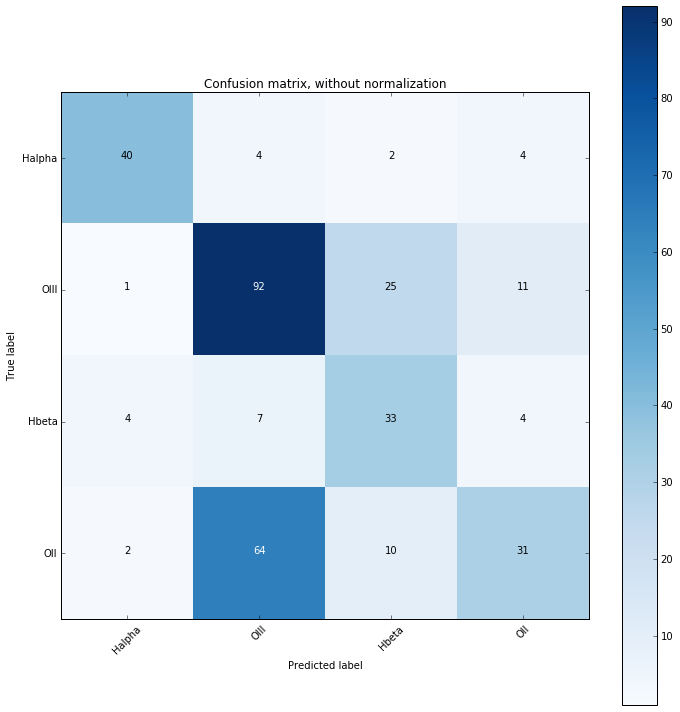

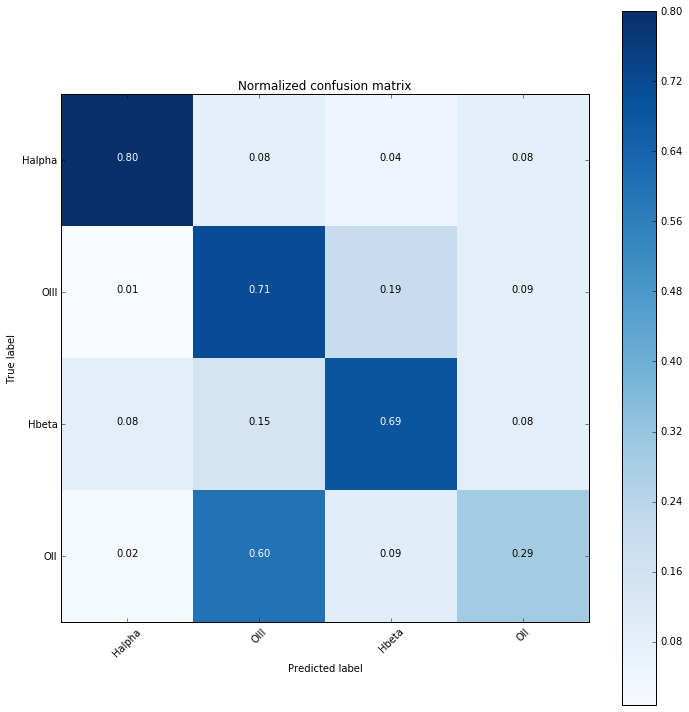

In [15]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(validate_class, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype,
                      title='Confusion matrix, without normalization', cmap = plt.cm.Blues)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

